In [4]:
# Part 0: Setup
###############

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.Programs.RelationalPrograms
using AlgebraicPetri
using AlgebraicPetri.Epidemiology
using AlgebraicPetri.BilayerNetworks
using Catlab.Graphics
using Test
include("../ASKE-E-Simulation-WG/AlgebraicPetri-Stratification/src/GrometInterop.jl");

┌ Info: Precompiling AlgebraicPetri [4f99eebe-17bf-4e98-b6a1-2c4f205a959b]
└ @ Base loading.jl:1423
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1423
ERROR: LoadError: UndefVarError: allows_arbitrary_number_types not defined
Stacktrace:
  [1] getproperty(x::Module, f::Symbol)
    @ Base ./Base.jl:35
  [2] top-level scope
    @ ~/.julia/packages/SteadyStateDiffEq/6hOEc/src/algorithms.jl:30
  [3] include(mod::Module, _path::String)
    @ Base ./Base.jl:418
  [4] include(x::String)
    @ SteadyStateDiffEq ~/.julia/packages/SteadyStateDiffEq/6hOEc/src/SteadyStateDiffEq.jl:1
  [5] top-level scope
    @ ~/.julia/packages/SteadyStateDiffEq/6hOEc/src/SteadyStateDiffEq.jl:9
  [6] include
    @ ./Base.jl:418 [inlined]
  [7] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
    @ Base

LoadError: LoadError: Failed to precompile DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa] to /Users/ksb/.julia/compiled/v1.7/DifferentialEquations/jl_OjLSxC.
in expression starting at /Users/ksb/code/ASKE-E-Simulation-WG/AlgebraicPetri-Stratification/src/GrometInterop.jl:1

In [3]:
using Pkg; Pkg.activate("/Users/ksb/code/ModelExploration.jl");
using Catlab
using ModelExploration

  Activating project at `~/code/ModelExploration.jl`
┌ Info: Precompiling Catlab [134e5e36-593f-5add-ad60-77f754baafbe]
└ @ Base loading.jl:1423
┌ Info: Precompiling ModelExploration [ee4b7b2d-0795-4448-a530-9f52182b79fb]
└ @ Base loading.jl:1423


# Example model


In [ ]:

SIR′ = LabelledReactionNet{Float64, Float64}([
    :S=>0.9, :I=>0.1, :R=>0.0],
    (:beta=>0.5) => ((:S,:I) => (:I,:I)),
    (:gamma=>0.05) => (:I=>:R))

SIR = LabelledPetriNet(SIR′) # no rates attached

Graph(SIR)


# Part 1: Code parsing/gen

A bilayer network is a representation of a restricted class of programs.
This is a data structure that we can target when parsing real code bases.

## Reading from Gromet

Input is a Gromet file containing SIR model data.

In [ ]:
println(join(open(readlines, `head -n 15 data/sir_gromet.json`),"\n"))

In [ ]:
bln = GrometInterop.gromet2bln("data/sir_gromet.json")
to_graphviz(bln)

In [ ]:
println(generate_json_acset(bln))

From bilayer networks, we can generate code which performs an ODE update step.

In [ ]:
BilayerNetworks.compile(bln, :du, :phi, :psi, rates(SIR′))

## Petri net <-> Bilayer Network

These two representations are interconvertible.

In [ ]:
bln2 = LabelledBilayerNetwork()
migrate!(bln2, LabelledPetriNet(SIR))

# round trip test
SIR′ = migrate!(LabelledPetriNet(), bln2)
@test is_isomorphic(SIR′, SIR);

# Part 2: Model composition

## a.) Stratification

In [ ]:
TwoCitySimple = LabelledPetriNet([:City1,:City2],
    :travel12 => ((:City1)=>(:City2)),
    :travel21 => ((:City2)=>(:City1)))

# Slightly more complex version needed to perform stratification
# Where each state given 'trivial' disease dynamics.
TwoCity = LabelledPetriNet([:City1,:City2],
    :travel12 => ((:City1)=>(:City2)),
    :travel21 => ((:City2)=>(:City1)),
    :disease1 => ((:City1)=>(:City1)),
    :disease2 => ((:City2)=>(:City2)),
    :inf1 => ((:City1,:City1)=>(:City1,:City1)),
    :inf2 => ((:City2,:City2)=>(:City2,:City2)))

Graph(TwoCitySimple)

In [ ]:
# SIR equipped with ability to stratify
#--------------------------------------

SIR = LabelledPetriNet([:S, :I, :R],
  :inf => ((:S, :I)=>(:I, :I)),
  :rec => (:I=>:R),
  :s_travel => (:S=>:S), 
  :i_travel => (:I=>:I),
  :r_travel => (:R=>:R),
);
Graph(SIR)

Stratification implicitly depends on assigning "types" to each of the elements of the model, which controls how the product is taken.

In [ ]:
types′ = LabelledPetriNet([:Pop],
    :interaction=>((:Pop, :Pop)=>(:Pop, :Pop)),
    :t_infection=>(:Pop=>:Pop),
    :t_strata=>(:Pop=>:Pop))
types = map(types′, Name=name->nothing) # names only needed for visualization
Graph(types′)

Here we assign types (i.e. pick a homomorphism from our models into `types`) and perform stratification using a `pullback`.

In [ ]:
SIR_typed = homomorphism(SIR, types;
    initial=(T=[1,2,3,3],I=[1,2,3,4,4,4],O=[1,2,3,4,4,4]),
    type_components=(Name=x->nothing,))

TwoCity_typed = homomorphism(TwoCity, types;
    initial=(T=[3,3,2,2,1,1],I=[4,4,3,3,1,2,1,2],O=[4,4,3,3,1,2,1,2]), type_components=(Name=x->nothing,))

SIR_2 = apex(pullback(SIR_typed, TwoCity_typed))
Graph(SIR_2)

## b.) Gluing

In [ ]:
ID = LabelledPetriNet([:I,:D],  :death => ((:I)=>(:D))) # Death transition
I = LabelledPetriNet([:I],) # "Overlap" between SIR and ID
Graph(ID)

In [ ]:
death_transition = Span(homomorphism(I, SIR), homomorphism(I, ID))
SIRD = apex(pushout(death_transition...)) # gluing
Graph(SIRD)

# Part 3: Model space composition 
Note some code below will work only in experimental versions of Catlab, which we are working towards officially releasing in the near future! 
## a.) Stratification

In [ ]:
# Other disease dynamics
SIRS = LabelledPetriNet([:S, :I, :R],
  :inf => ((:S, :I)=>(:I, :I)),
  :rec => (:I=>:R),
  :sus => (:R=>:S),
  :s_travel => (:S=>:S), 
  :i_travel => (:I=>:I),
  :r_travel => (:R=>:R),
)

Graph(SIRS)

In [ ]:
# Other strata model
OneCity = LabelledPetriNet([:City1],
    :disease1 => ((:City1)=>(:City1)),
    :inf1 => ((:City1,:City1)=>(:City1,:City1)))

Graph(OneCity)


We now have two disease models (SIR, SIRS) and two strata models (one-city, two-city). We can consider each as the first two elements of some space of models.

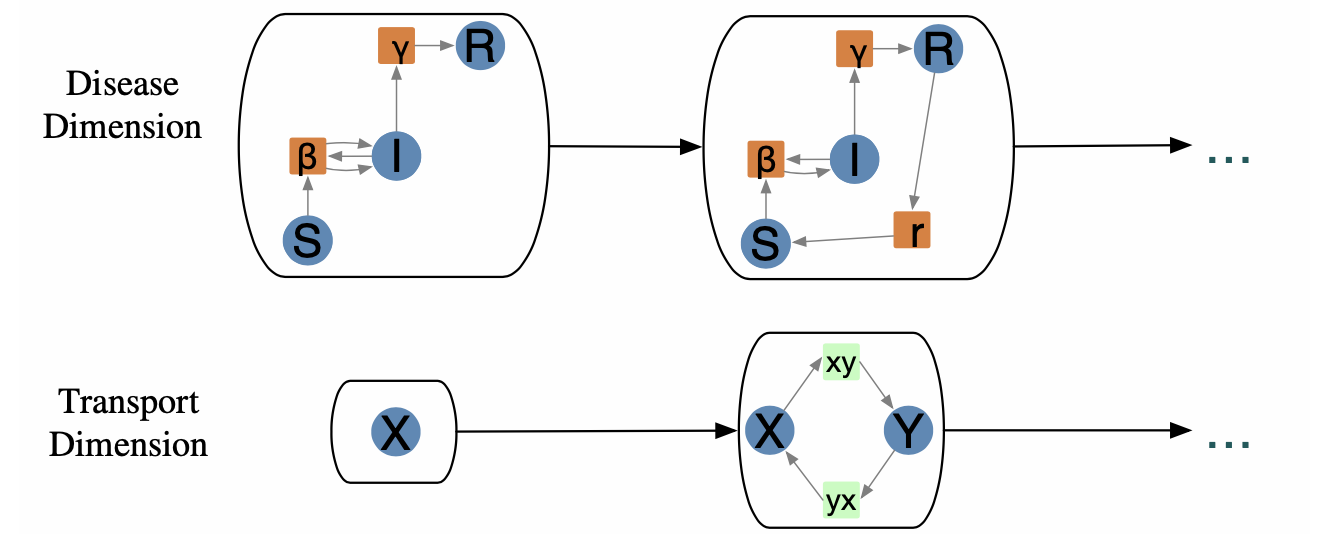

We can take the product of these two dimensions

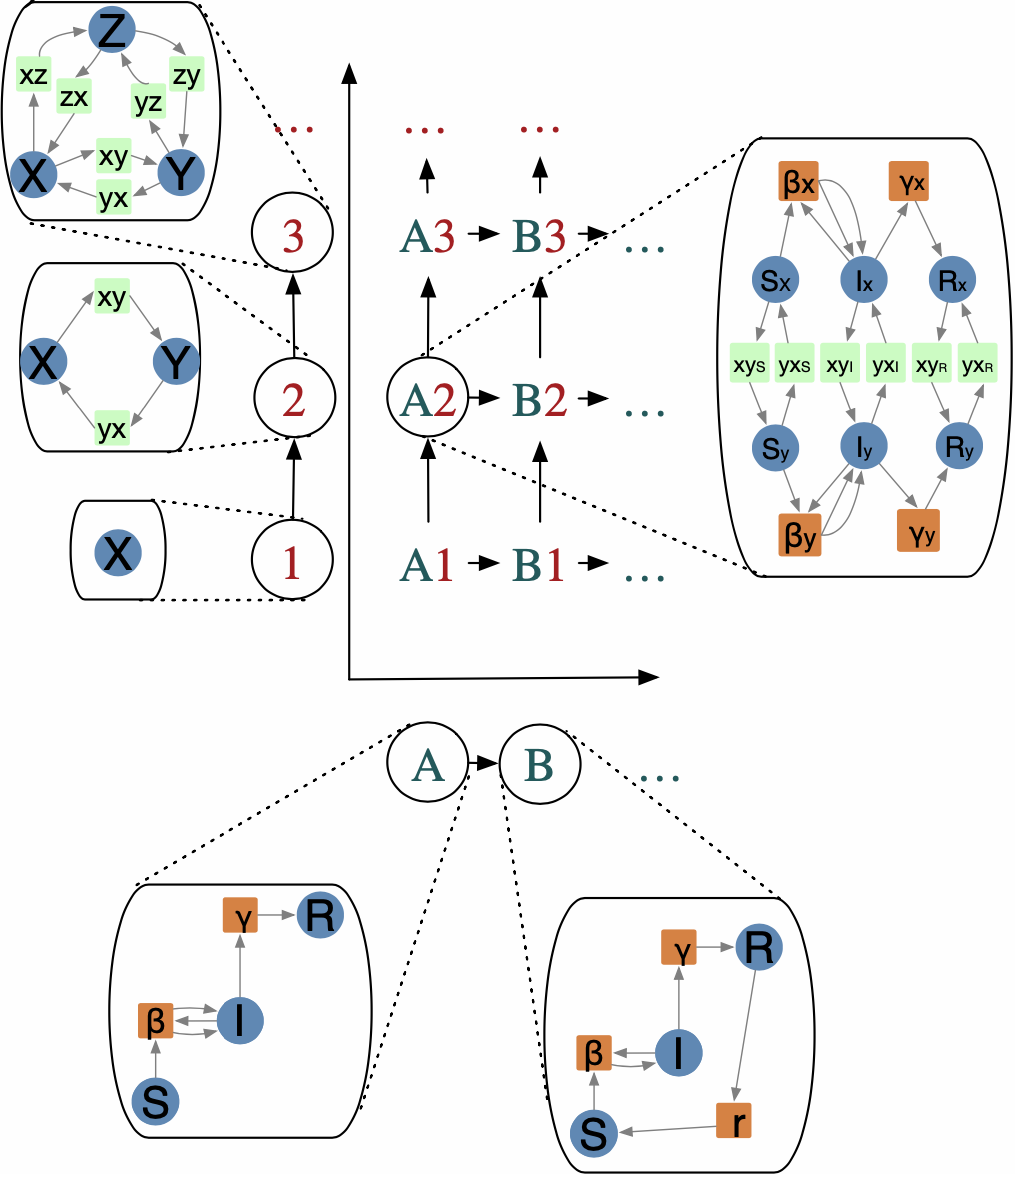

The data structure that represents model spaces is a `Diagram`.

```julia
One_two = homomorphism(OneCity, TwoCity)
SIR_SIRS = homomorphism(SIR, SIRS)

diag_strata = Diagram(One_two)
diag_disease = Diagram(SIR_SIRS)

@test length(pullback(diag_disease, diag_strata))==4
```

### b.) Gluing 

Attaching the death transition to a space of models via an operation `glue`: 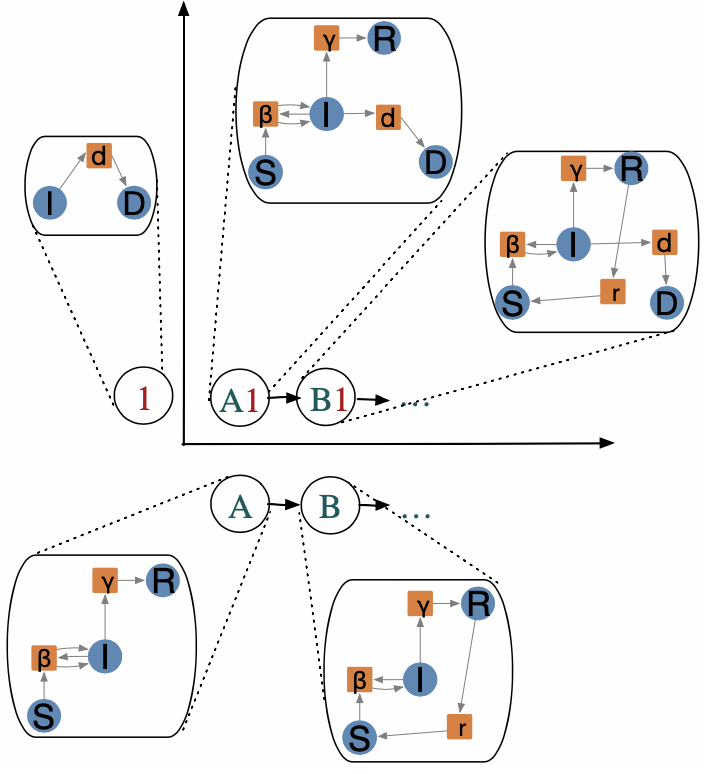

## Stratification and Gluing Combined

Our overall model space, represented as a composition of high level metamodeling operations.
 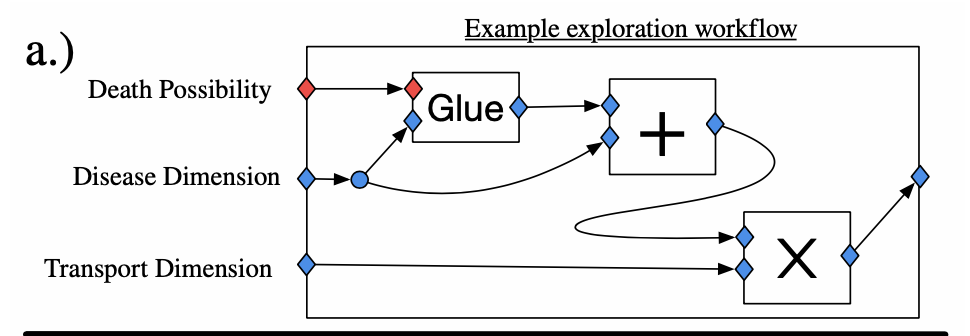

```julia 
death_dimension = glue(diag_disease, death_transition)
disease_plus_death = coproduct(diag_disease, death_dimension)
modelspace = pullback(disease_plus_death, diag_strata)
```

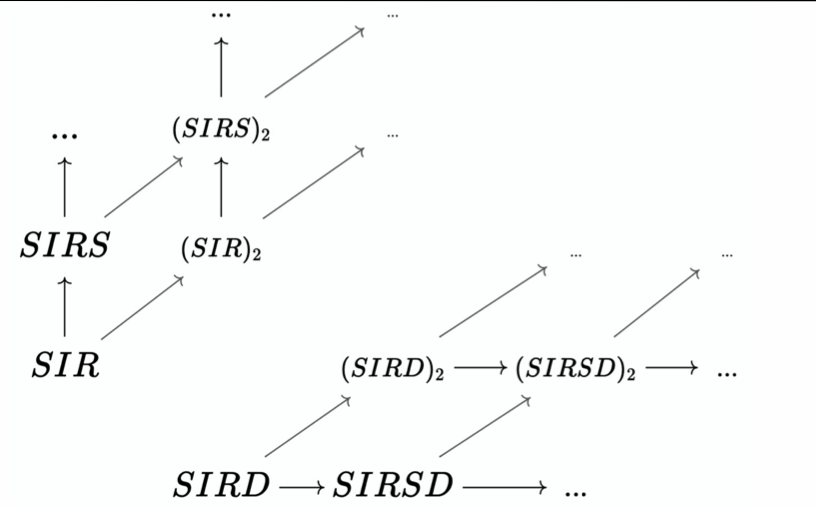

# Part 4: Model selection

### Generate data

```julia 
tspan = (0.0, 50.0);
p = [.001, .002, .01, .02, .005, .01, .005, 0.01, 0.0025, .001, 0.001, 0.01];
u0 = [400.0, 10.0, 0.0, 0.0, 200.0, 0.0, 0.0, 0.0];
true_model = SIRD2;
sample_data, sample_times, prob, sol = generate_data(true_model, p, u0, tspan, 50);
```

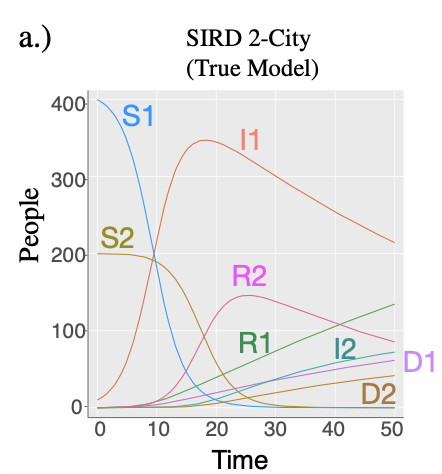

### Evaluate models

```julia
for model in modelspace
    sol, loss = full_train(model, u0, tspan, sample_data, sample_times, name)
end
```

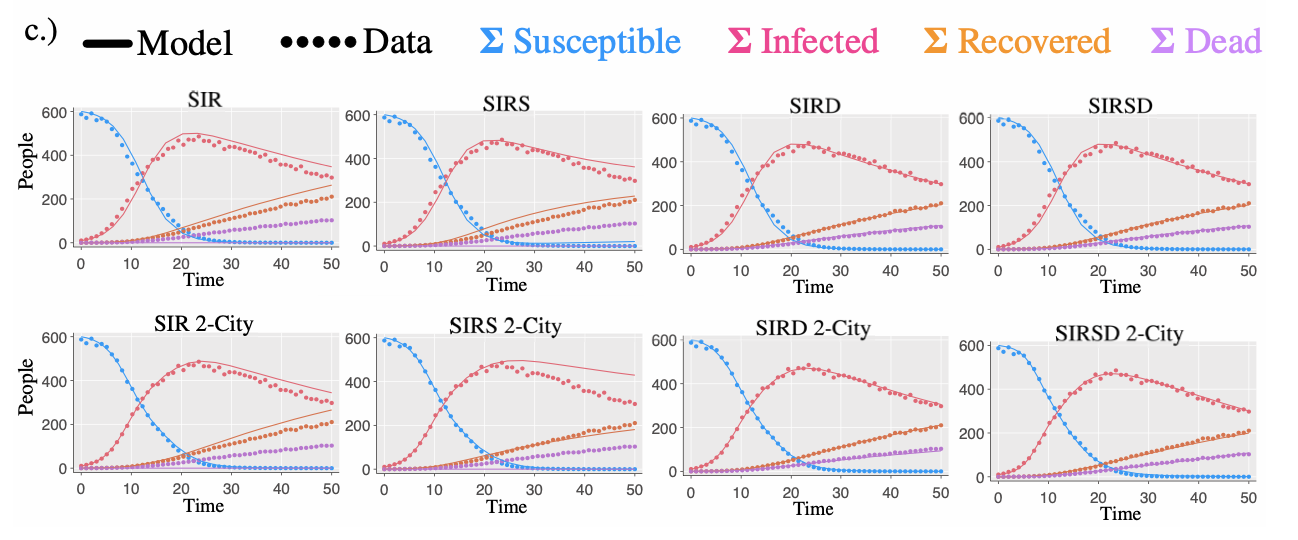

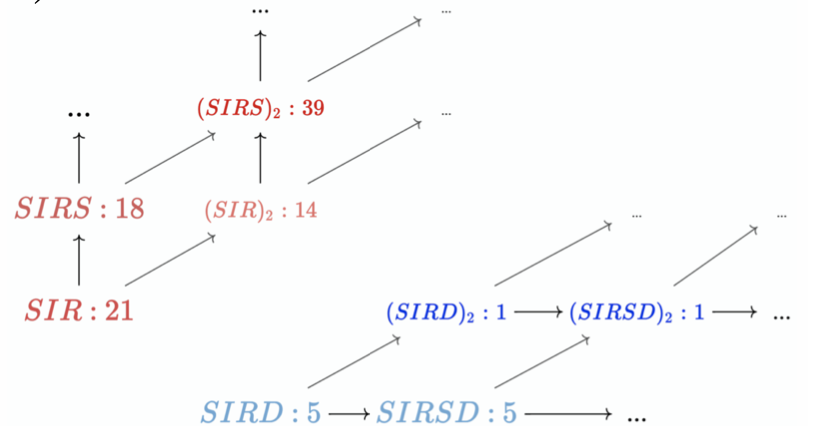